In [1]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from numpy.linalg import pinv
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from datetime import datetime, timedelta

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA

from keras.models import Sequential
from keras.utils import plot_model
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from sklearn.linear_model import LinearRegression
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
this_dir = os.getcwd()
parent_dir = os.path.dirname(os.path.normpath(this_dir))
plots_dir = os.path.join(parent_dir, 'plots', 'forecasting')
preproc_dir = os.path.join(parent_dir, 'preproc_files')
f_store_dfs = os.path.join(preproc_dir, 'store_dfs')
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

In [3]:
with open(f_store_dfs, 'rb') as f:
    df_dict = pickle.load(f)
df = df_dict['Store 5']

In [4]:
colors = mcolors.CSS4_COLORS
colors = [x for x in list(colors.keys()) if 'blue' in x or 'turquoise' in x or 'cyan' in x]
colors.sort()
colors = colors[::-1]
print(colors)

['turquoise', 'steelblue', 'slateblue', 'skyblue', 'royalblue', 'powderblue', 'paleturquoise', 'midnightblue', 'mediumturquoise', 'mediumslateblue', 'mediumblue', 'lightsteelblue', 'lightskyblue', 'lightcyan', 'lightblue', 'dodgerblue', 'deepskyblue', 'darkturquoise', 'darkslateblue', 'darkcyan', 'darkblue', 'cyan', 'cornflowerblue', 'cadetblue', 'blueviolet', 'blue', 'aliceblue']


In [5]:
def process_week(df):
    df['Week'] = df['Sale Date'].apply(lambda x: x - timedelta(days=x.weekday()))
    return df
    
def process_df_by_week_univariate(df):
    df = df.groupby(['Week'])['Sales'].sum()
    df.index = pd.DatetimeIndex(df.index)
    return df

def get_test_train_split(df, split=0.2):
    split_nb = int(len(df)*split)
    train, test = df.iloc[:-split_nb+1], df.iloc[-split_nb:]
    train.index = pd.to_datetime(train.index)
    test.index = pd.to_datetime(test.index)
    return train, test

In [6]:
def eliminate_trends_rolling_mean(df):
    roll = df.rolling(4).mean()
    avg_diff = (df - roll)/roll
    avg_diff.dropna(inplace=True)
    return avg_diff

def single_order_differencing(df):
    diff = df - df.shift()
    diff.dropna(inplace=True)
    return diff

def test_dickey_fuller_stationarity(df):
    rolmean = df.rolling(4).mean()
    rolstd = df.rolling(4).std()
    orig = plt.plot(df, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic',
                                             'p-value',
                                             '#Lags Used',
                                             'Number of Observations Used'])
    conf = 0.
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        if dfoutput['Test Statistic'] < dfoutput['Critical Value (%s)'%key]:
            dummy = 100 - int(key.split('%')[0])
            if dummy > conf:
                conf = dummy
    if conf > 95:
        return dfoutput, 'YES'
    else:
        return dfoutput, 'NO'

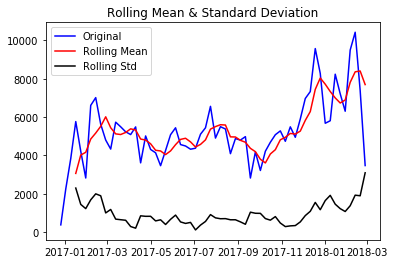

IS THE TIME SERIES STATIONARY? -  NO


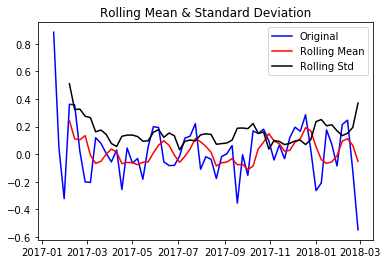

IS THE TREND ELIMINATED TIME SERIES STATIONARY? -  NO


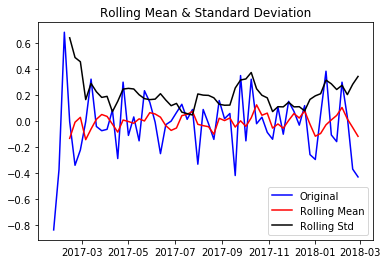

IS THE TREND ELIMINATED AND DIFFERENCED TIME SERIES STATIONARY? -  YES


In [7]:
df = process_week(df)
df = process_df_by_week_univariate(df)
rm_df = eliminate_trends_rolling_mean(df)
diff_df = single_order_differencing(rm_df)
_, res = test_dickey_fuller_stationarity(df)
print('IS THE TIME SERIES STATIONARY? - ', res)
_, res = test_dickey_fuller_stationarity(rm_df)
print('IS THE TREND ELIMINATED TIME SERIES STATIONARY? - ', res)
_, res = test_dickey_fuller_stationarity(diff_df)
print('IS THE TREND ELIMINATED AND DIFFERENCED TIME SERIES STATIONARY? - ', res)


In [8]:
def exponential_smoothing(df, smoothing_level=0.2):
    model = SimpleExpSmoothing(np.asarray(df))
    model._index = pd.to_datetime(df.index)
    fit = model.fit(smoothing_level=smoothing_level)   
    return fit

def holts_linear_smoothing(df, smoothing_level=0.3, smoothing_slope=0.05):
    model = Holt(np.asarray(df))
    model._index = pd.to_datetime(df.index)
    fit = model.fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope)   
    return fit
    
def holts_exponential_smoothing(df, trend=None, damped=False, seasonal=None, seasonal_periods=None):
    model = ExponentialSmoothing(np.asarray(df), trend=trend, seasonal=seasonal, damped=damped, seasonal_periods=seasonal_periods)
    model._index = pd.to_datetime(df.index)
    fit = model.fit()
    return fit

In [9]:
def smoothing_experiments(train, test, params, method, plot_dir):
    methods = ['simpl_exp', 'holts_lin', 'holts_exp']
    models = {}
    preds = {}
    rmse = {}
    if method == methods[0]:
        for s in params['smoothing_level']:
            models[s] = exponential_smoothing(train, smoothing_level=s)
            preds[s] = models[s].predict(start=1,end=len(test))
            preds[s] -= preds[s][0]
            preds[s] += train.values[-1]
            rmse[s] = np.sqrt(mean_squared_error(test, preds[s]))
    elif method == methods[1]:
        for sl in params['smoothing_level']:
            for ss in params['smoothing_slope']:
                models[(sl,ss)] = holts_linear_smoothing(train, smoothing_level=sl, smoothing_slope=ss)
                preds[(sl,ss)] = models[(sl,ss)].predict(start=1,end=len(test))                
                preds[(sl,ss)] -= preds[(sl,ss)][0]
                preds[(sl,ss)] += train.values[-1]
                rmse[(sl,ss)] = np.sqrt(mean_squared_error(test, preds[(sl,ss)]))
    elif method == methods[2]:
        for t in params['trend']:
            for d in params['damped']:
                models[(t,d)] = holts_exponential_smoothing(train, trend=t, damped=d)
                preds[(t,d)] = models[(t,d)].predict(start=1,end=len(test))
                preds[(t,d)] -= preds[(t,d)][0]
                preds[(t,d)] += train.values[-1]
                rmse[(t,d)] = np.sqrt(mean_squared_error(test, preds[(t,d)]))
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(train.index, train.values, color="gray")
    ax.plot(test.index, test.values, color="gray")
    for p, f, r, c in zip(list(preds.values()),list(models.values()),list(rmse.values()),colors[:len(preds)]):
#         ax.plot(train.index, f.fittedvalues, color=c)
        if method == methods[0]:
            ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:3]+" RMSE: "+str(r), color=c)
            ax.set_title("Simple Exponential Smoothing")    
            ax.legend();
        elif method == methods[1]:
            ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4]+" RMSE: "+str(r), color=c)
            ax.set_title("Holts Linear Smoothing")    
            ax.legend();
        elif method == methods[2]:
            ax.plot(test.index, p, 
                    label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4]+ ", damping="+str(True if f.params['damping_slope']>0 else False)+" RMSE: "+str(r), 
                    color=c)
            ax.set_title("Holts Exponential Smoothing")    
            ax.legend();
    plot_name = method + '.png'
    fig.savefig(os.path.join(plot_dir, plot_name))
    return models, preds, rmse

In [10]:
simpl_exp_params = {
    'smoothing_level': [0.2, 0.3, 0.5],
}

holts_lin_params = {
    'smoothing_level': [0.2, 0.3, 0.5],
    'smoothing_slope': [0.05, 0.1, 0.2],
}

holts_exp_params = {
    'trend': ['add'],
    'damped': [False, True],
}

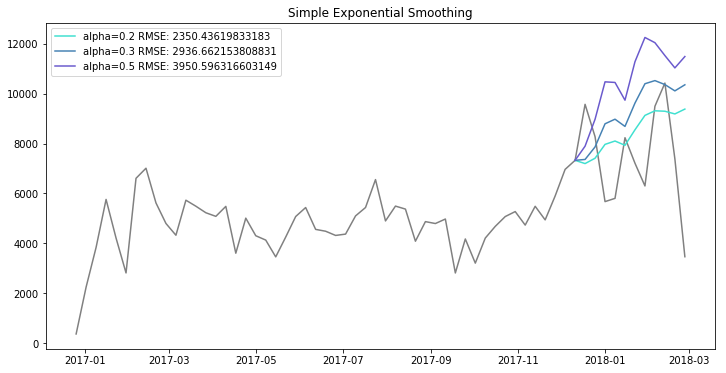

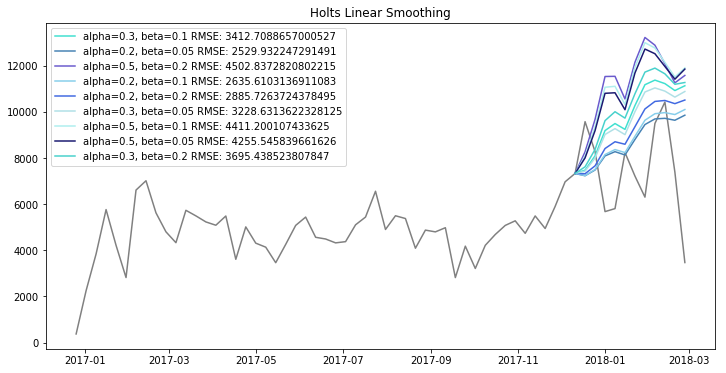

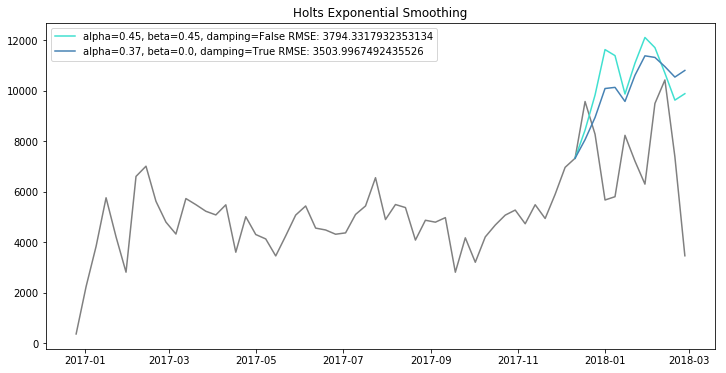

In [11]:
train, test = get_test_train_split(df, split=0.2)
smoothing_plots_dir = os.path.join(plots_dir, 'smoothing')
smoothing_exp_dir = os.path.join(smoothing_plots_dir, 'experiments')
if not os.path.exists(smoothing_exp_dir):
    os.makedirs(smoothing_exp_dir)

simpl_exp_models, simpl_exp_preds, simpl_exp_rmse = smoothing_experiments(train, test, simpl_exp_params, 'simpl_exp', smoothing_exp_dir)
holts_lin_models, holts_lin_preds, holts_lin_rmse = smoothing_experiments(train, test, holts_lin_params, 'holts_lin', smoothing_exp_dir)
holts_exp_models, holts_exp_preds, holts_exp_rmse = smoothing_experiments(train, test, holts_exp_params, 'holts_exp', smoothing_exp_dir)

In [12]:
def get_best_model(rmse):
    min_rmse = min(rmse.values())
    best = [key for key in rmse if rmse[key] == min_rmse]
    return best[0]

best1 = get_best_model(simpl_exp_rmse)
best2 = get_best_model(holts_lin_rmse)
best3 = get_best_model(holts_exp_rmse)

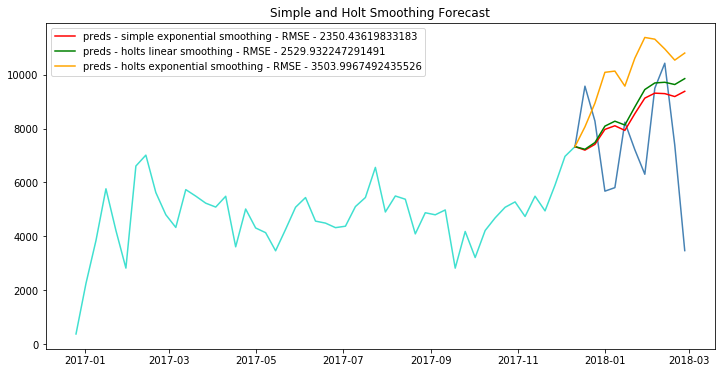

In [13]:
train, test = get_test_train_split(df, split=0.2)

plt.figure(figsize=(12,6))
plt.plot(train.index, train.values, color=colors[0])
plt.plot(test.index, test.values, color=colors[1])
plt.title('Simple and Holt Smoothing Forecast')

preds = simpl_exp_preds[best1]
rmse = np.sqrt(mean_squared_error(test, preds))
plt.plot(test.index[:len(preds)], preds, color='red', label='preds - simple exponential smoothing - RMSE - {}'.format(rmse))
plt.legend()

preds = holts_lin_preds[best2]
rmse = np.sqrt(mean_squared_error(test, preds))
plt.plot(test.index[:len(preds)], preds, color='green', label='preds - holts linear smoothing - RMSE - {}'.format(rmse))
plt.legend()

preds = holts_exp_preds[best3]
rmse = np.sqrt(mean_squared_error(test, preds))
plt.plot(test.index[:len(preds)], preds, color='orange', label='preds - holts exponential smoothing - RMSE - {}'.format(rmse))
plt.legend()

smoothing_plots_dir = os.path.join(plots_dir, 'smoothing')
plt.savefig(os.path.join(smoothing_plots_dir, 'best_forecasts.png'))

In [14]:
ARIMA_exp_dir = os.path.join(plots_dir, 'ARIMA', 'experiments')
if not os.path.exists(ARIMA_exp_dir):
    os.makedirs(ARIMA_exp_dir)
    
def get_acf_pacf_plots(df):
    fig, ax = plt.subplots(2, figsize=(12,6))
    ax[0] = plot_acf(df, ax=ax[0], lags=20)
    ax[1] = plot_pacf(df, ax=ax[1], lags=20, method='ols')
    fig.savefig(os.path.join(ARIMA_exp_dir, 'acf_pacf.png'))

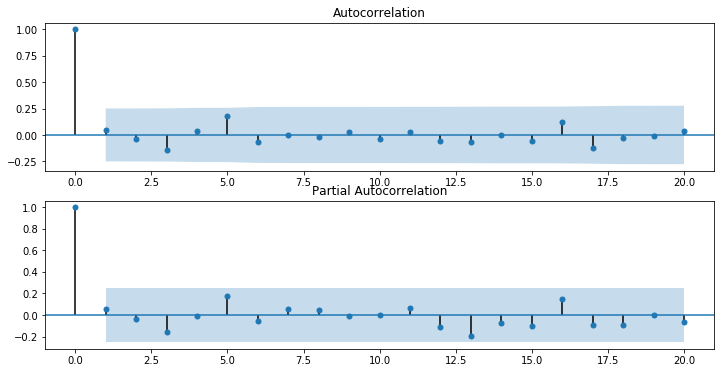

In [15]:
log_df = np.log(df)
diff_df = single_order_differencing(log_df)
get_acf_pacf_plots(diff_df)

In [16]:
def AR_model(df, p=1):
    model = ARIMA(df, order=(p, 1, 0))  
    results_AR = model.fit(disp=-1)
    plt.figure(figsize=(12,6))
    plt.plot(df, label='original')
    plt.plot(results_AR.fittedvalues, color='red', label='fit')
    rmse = np.sqrt(mean_squared_error(df[1:], results_AR.fittedvalues))
    plt.title('AR_model - RMSE - {}'.format(rmse))
    plt.legend()
    plt.savefig(os.path.join(ARIMA_exp_dir, 'results_AR.png'))
    return results_AR
    
def MA_model(df, q=1):
    model = ARIMA(df, order=(0, 1, q))  
    results_MA = model.fit(disp=-1) 
    plt.figure(figsize=(12,6))
    plt.plot(df, label='original')
    plt.plot(results_MA.fittedvalues, color='red', label='fit')
    rmse = np.sqrt(mean_squared_error(df[1:], results_MA.fittedvalues))
    plt.title('MA_model - RMSE - {}'.format(rmse))
    plt.legend()
    plt.savefig(os.path.join(ARIMA_exp_dir, 'results_MA.png'))
    return results_MA
    
def ARIMA_model(df, p=1, q=1, r=1):
    model = ARIMA(df, order=(p, r, q))  
    results_ARIMA = model.fit(disp=-1)
    plt.figure(figsize=(12,6))
    plt.plot(df, label='original')
    plt.plot(results_ARIMA.fittedvalues, color='red', label='fit')
    rmse = np.sqrt(mean_squared_error(df[1:], results_ARIMA.fittedvalues))
    plt.title('ARIMA_model - RMSE - {}'.format(rmse))
    plt.legend()
    plt.savefig(os.path.join(ARIMA_exp_dir, 'results_ARIMA.png'))
    return results_ARIMA

/home/anujsable/anaconda3/envs/tf_gpu/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)
/home/anujsable/anaconda3/envs/tf_gpu/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  % freq, ValueWarning)
/home/anujsable/anaconda3/envs/tf_gpu/lib/python3.5/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/anujsable/anaconda3/envs/tf_gpu/lib/python3.5/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensi

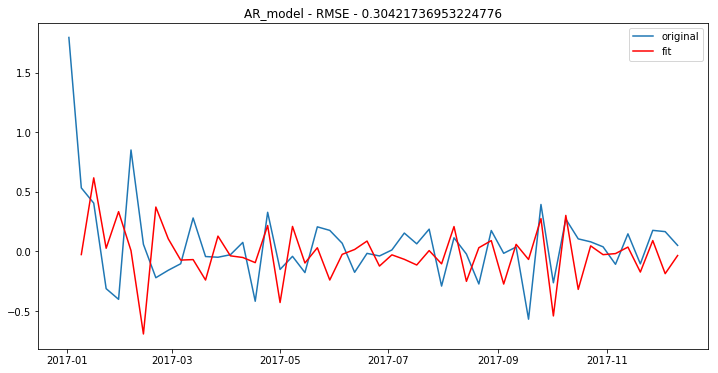

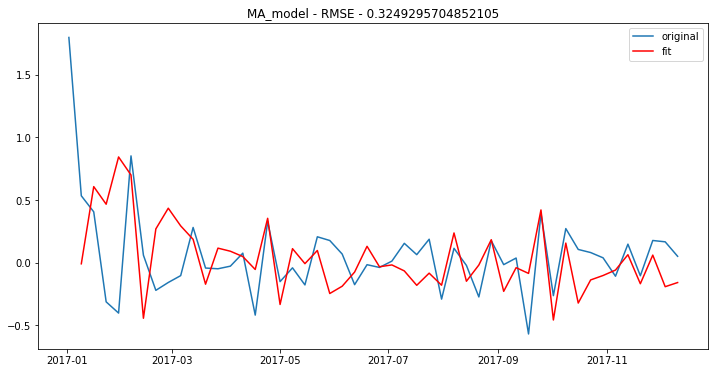

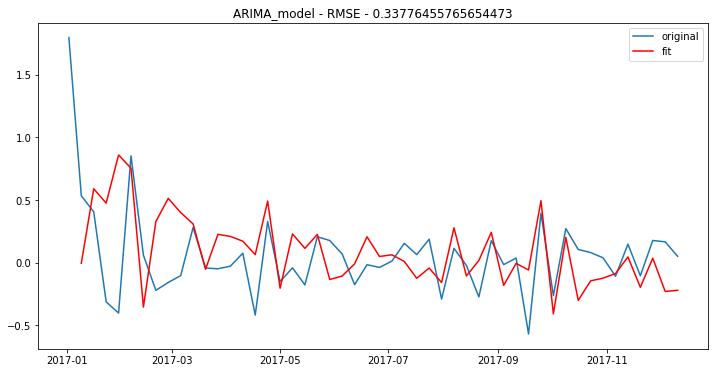

In [17]:
p = 1
q = 1
r = 1
train, test = get_test_train_split(diff_df, split=0.2)
results_AR = AR_model(train, p=p)
results_MA = MA_model(train, q=q)
results_ARIMA = ARIMA_model(train, p=p, q=q, r=1)

/home/anujsable/anaconda3/envs/tf_gpu/lib/python3.5/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


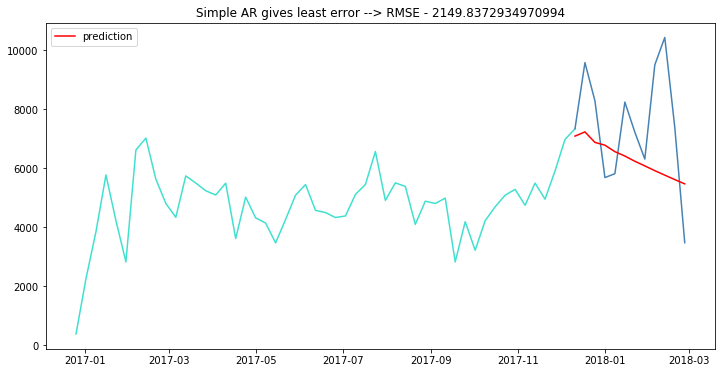

In [18]:
train, test = get_test_train_split(df, split=0.2)
ARIMA_plots_dir = os.path.join(plots_dir, 'ARIMA')

arima_preds = results_AR.predict(start=test.index[0],end=test.index[-1])
preds_cumsum = arima_preds.cumsum()
log_preds = pd.Series(np.log(train).ix[-1], index=test.index)
log_preds = log_preds.add(preds_cumsum,fill_value=0)
preds = np.exp(log_preds)
rmse = np.sqrt(mean_squared_error(test, preds))

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(train.index, train.values, color=colors[0])
plt.plot(test.index, test.values, color=colors[1])
ax.plot(test.index, preds, label='prediction', color='red')
ax.set_title('Simple AR gives least error --> RMSE - {}'.format(rmse))
ax.legend()
fig.savefig((os.path.join(ARIMA_plots_dir, 'forecasts_AR.png')))

In [19]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

train, test = get_test_train_split(df, split=0.2)
X_train, y_train = split_sequence(train, n_steps=6)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 100)               20800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________


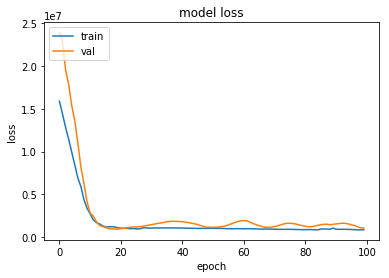

In [20]:
BiLSTMs_plots_dir = os.path.join(plots_dir, 'BiLSTMs')
BiLSTMs_exps_dir = os.path.join(BiLSTMs_plots_dir, 'experiments')
if not os.path.exists(BiLSTMs_exps_dir):
    os.makedirs(BiLSTMs_exps_dir)

n_steps = 6
n_features = 1
X = X_train.copy()
X = X.reshape((X.shape[0], X.shape[1], n_features))

model = Sequential()
lstm_layer = LSTM(50, activation='relu')
model.add(Bidirectional(lstm_layer, input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()
plot_model(model, to_file=os.path.join(BiLSTMs_plots_dir, 'biLSTM_arch.png'))

history = model.fit(X, y_train, epochs=100, validation_split=0.1, verbose=0)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(os.path.join(BiLSTMs_exps_dir, 'biLSTM_train_loss.png'))
plt.show()

100%|██████████| 12/12 [00:00<00:00, 57.50it/s]


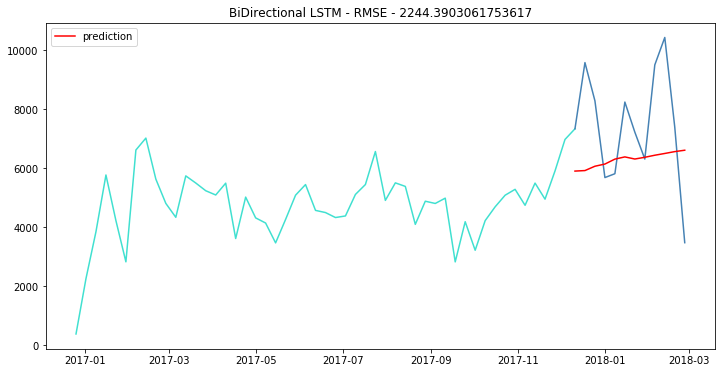

In [21]:
preds = []
test_seq = X[-1:,:,:]
preds = []
for x in tqdm(range(len(test))):
    preds.append(model.predict(test_seq, verbose=0)[0])
    test_seq = np.append(test_seq.flatten()[1:], preds[-1])
    test_seq = test_seq.reshape((1, n_steps, n_features))

rmse = np.sqrt(mean_squared_error(preds, test))

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(train.index, train.values, color=colors[0])
plt.plot(test.index, test.values, color=colors[1])
ax.plot(test.index, preds, label='prediction', color='red')
ax.set_title('BiDirectional LSTM - RMSE - {}'.format(rmse))
fig.savefig(os.path.join(BiLSTMs_plots_dir, 'biLSTM_forecast.png'))
ax.legend()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, None, 2, 64)       128       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1, 64)       0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 64)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                23000     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 23,179
Trainable params: 23,179
Non-trainable params: 0
_________________________________________________________________


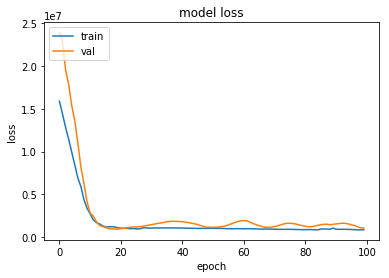

In [22]:
ConvLSTMs_plots_dir = os.path.join(plots_dir, 'ConvLSTMs')
ConvLSTMs_exps_dir = os.path.join(ConvLSTMs_plots_dir, 'experiments')
if not os.path.exists(ConvLSTMs_exps_dir):
    os.makedirs(ConvLSTMs_exps_dir)
    
n_features = 1
n_seq = 3
n_steps = 2

X = X_train.copy()
X = X.reshape((X.shape[0], n_seq, n_steps, n_features))

model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()
plot_model(model, to_file=os.path.join(ConvLSTMs_plots_dir, 'ConvLSTM_arch.png'))

model.fit(X, y_train, epochs=100, validation_split=0.1, verbose=0)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(os.path.join(ConvLSTMs_exps_dir, 'ConvLSTM_train_loss.png'))
plt.show()

100%|██████████| 12/12 [00:00<00:00, 78.00it/s]


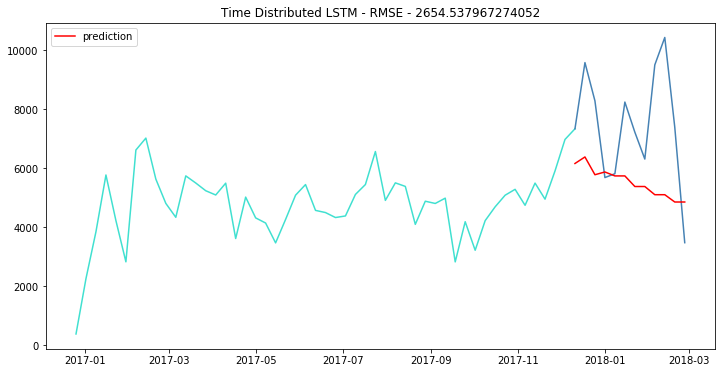

In [23]:
preds = []
test_seq = X[-1:,:,:,:]
preds = []

for x in tqdm(range(len(test))):
    preds.append(model.predict(test_seq, verbose=0)[0])
    test_seq = np.append(test_seq.flatten()[1:], preds[-1])
    test_seq = test_seq.reshape((1, n_seq, n_steps, n_features))

rmse = np.sqrt(mean_squared_error(preds, test))
    
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(train.index, train.values, color=colors[0])
plt.plot(test.index, test.values, color=colors[1])
ax.plot(test.index, preds, label='prediction', color='red')
ax.set_title('Time Distributed LSTM - RMSE - {}'.format(rmse))
fig.savefig(os.path.join(ConvLSTMs_plots_dir, 'ConvLSTM_forecast.png'))
ax.legend()

/home/anujsable/anaconda3/envs/tf_gpu/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
100%|██████████| 12/12 [00:00<00:00, 13354.11it/s]


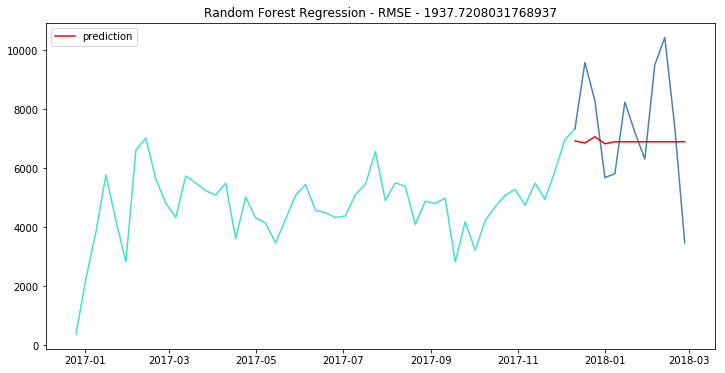

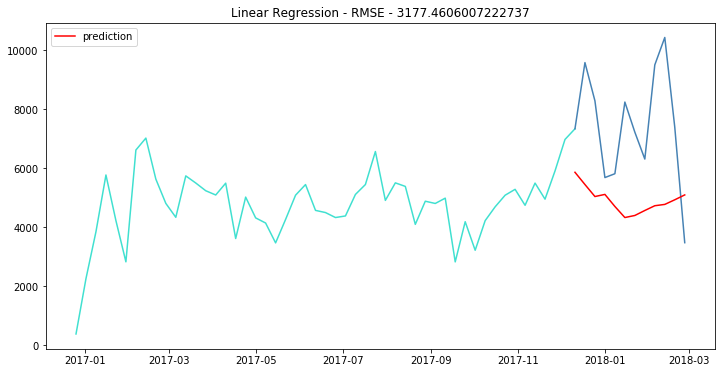

In [24]:
regr_plots_dir = os.path.join(plots_dir, 'regression')
if not os.path.exists(regr_plots_dir):
    os.makedirs(regr_plots_dir)

n_steps = 6
regr = {}
regr['lin_reg'] = LinearRegression(normalize=True)
regr['rand_forest'] = RandomForestRegressor()
    
for model in regr:
    regr[model].fit(X_train, y_train)
    test_seq = X_train[-1:,:]
    preds = []
    for x in tqdm(range(len(test))):
        preds.append(regr[model].predict(test_seq)[0])
        test_seq = np.append(test_seq.flatten()[1:], preds[-1])
        test_seq = test_seq.reshape((1, n_steps))
    rmse = np.sqrt(mean_squared_error(preds, test))
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.plot(train.index, train.values, color=colors[0])
    plt.plot(test.index, test.values, color=colors[1])
    ax.plot(test.index, preds, label='prediction', color='red')
    if model=='lin_reg':
        ax.set_title('Linear Regression - RMSE - {}'.format(rmse))
    else:
        ax.set_title('Random Forest Regression - RMSE - {}'.format(rmse))
    ax.legend()
    fig.savefig(os.path.join(regr_plots_dir, model+'_forecast.png'))